# Vetor autorregressivo usando o Python

### Autores:
* Bruno Henrique Golfette: @brunohg
* Maisa Kely de Melo: @maisakmelo

# Objetivos do arquivo:

* Compreender a fórmula do vetor autorregressivo
* Verificar se as séries influenciam-se mutuamente usando o Teste de Granger
* Aprender o procedimento para construir um modelo VAR no Python
* Aprender a determinar a ordem do modelo VAR
* Interpretar os resultados do modelo VAR
* Voltar os valores previstos para a escala original da série temporal

Modelo autorregressivo vetorial (VAR) é um algoritmo de previsão usado quando duas ou mais séries influenciam-se mutuamente. Na prática, é um modelo de regressão que trata todas as variáveis como endógenas e permite que cada uma delas dependam de p valores de lags passados, esses valores são da própria série e das outras séries.

Os requerimentos básicos para usar o VAR são:

* Haver pelo menos duas séries
* As série devem influenciar uma na outra
* As séries devem ser estacionárias

### Matematicamente

Um modelo autorregressivo vetorial de ordem *p* é um processo que pode ser representado como:

* yt é um vetor Nx1 que contém N variáveis endógenas 
 * variáveis endógenas são determinadas dentro do modelo --> representam a saída do modelo
* a0 é um vetor Nx1 de constantes
* A1,A2,...,Ap são matrizes pNxN de coeficientes autorregressivos
* ut é um vetor Nx1 que representa um ruído branco

# Passo a passo para construir o modelo VAR:

1. Analisar as características da série
2. Verificar se as séries influenciam uma a outra
3. Verificar se as séries são estacionárias
4. Se as séries não forem estacionárias, torná-las estacionárias
5. Encontrar a ordem do VAR (p)
6. Separar a base de dados em: treinamento e teste
7. Treinar o modelo
8. Fazer as previsões
9. Fazer uma transformação para voltar as previsões à escala original
10. Plotar as previsões *versus* os dados reais
11. Analisar os resultados obtidos

# Pacotes necessários

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Base de dados

Neste artigo usamos preços de fechamentos diários de cinco ativos da B3 para o período 04/01/2016 a 31/01/2018

Ativos utilizados:

1. **MRVE3**: MRV Engenharia
2. **ENBR3**: Energias BR
3. **CMIG4**: Cemig
4. **EQTL3**: Equatorial Energia
5. **LREN3**: Lojas Renner

In [3]:
df = pd.read_excel('Correlacao.xlsx', sheet_name='Variados')
df_copy = df.copy()
df.set_index('Data', inplace = True)
df = df[df.columns[:5]]
print(df.shape) #(516,5)
df.head()

(516, 5)


,MRVE3,ENBR3,CMIG4,EQTL3,LREN3
Data,,,,,
2016-01-04,7.555,9.711,4.580,31.407,14.095
2016-01-05,7.700,10.219,4.451,32.930,15.099
2016-01-06,7.519,10.288,4.224,33.120,15.012
2016-01-07,7.482,9.650,3.990,32.206,14.767
2016-01-08,7.492,9.995,3.803,32.644,14.732


# <font color='green'>**PASSO 1:**</font> Visualização das séries temporais

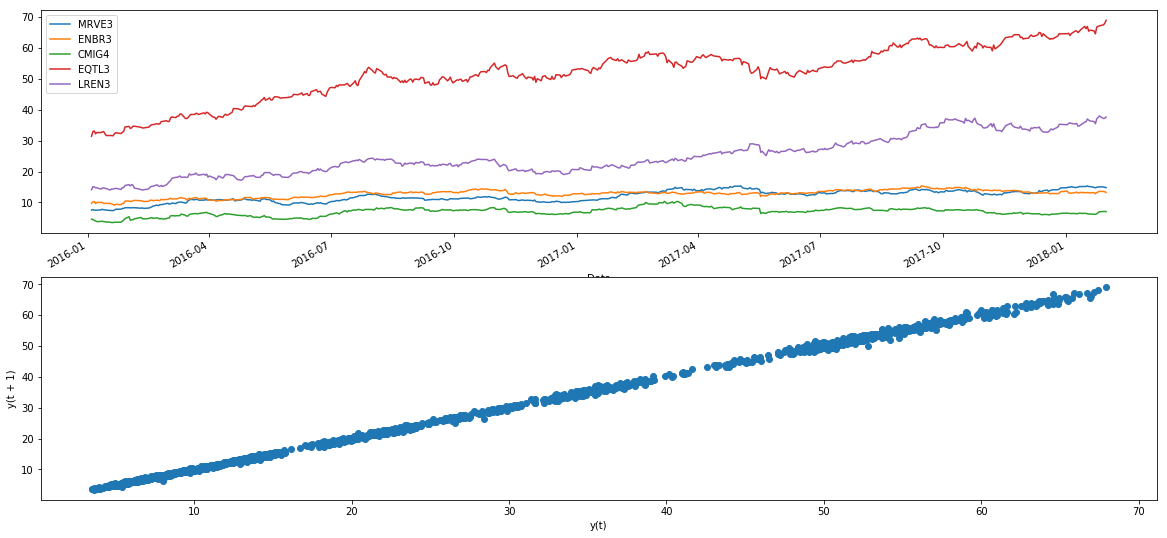

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
df.plot(ax=ax1) # series plot
pd.plotting.lag_plot(df) # lag plot

## Observação

* As séries temporais indicam algum tipo de relação entre os dados.
* A forma linear do gráfico de lags sugere que o VAR é mesmo a melhor escolha.

# <font color='green'>**PASSO 2:**</font> Teste de *Causation* usando o teste de Granger

Este teste responde à pergunta:
### <font color='green'>**As séries influenciam uma a outra?**</font>

* Teste de causalidade de Granger verifica todas as possíveis combinações das séries temporais.
* As linhas são as variáveis resposta.
* As colunas são os preditores.
* Os valores na tabela são os *p*-valores.
* <font color='green'>**Hipótese Nula**</font>: os coeficientes dos valores correspondentes passados são zero (X não influencia Y)
* *p*-valores menores que 0.05 (nível de significância) implicam que a Hipótese Nula pode ser rejeitada.
*  <font color='green'>**data**</font>: Dataframe em pandas contendo as séries temporais
*  <font color='green'>**variables**</font>: Lista contendo os nomes das variáveis das séries temporais (nome dos ativos)

In [5]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=1

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

def ImprimeGT(data):
    variables=data.columns
    df = grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False)
    print(grangers_causation_matrix(df, variables=df.columns))
    return

ImprimeGT(df)

           MRVE3_x_x  ENBR3_x_x  CMIG4_x_x  EQTL3_x_x  LREN3_x_x
MRVE3_x_y     1.0000     0.1171     0.0000     0.0000     0.0006
ENBR3_x_y     0.6244     1.0000     0.0000     0.4733     0.0000
CMIG4_x_y     0.0164     0.1016     1.0000     0.0410     0.0157
EQTL3_x_y     0.0000     0.0510     0.0012     1.0000     0.0000
LREN3_x_y     0.0001     0.0232     0.4289     0.1099     1.0000


### Como ler os resultados acima?

* Considere o valor 0.0006 (linha 1, coluna 5).
* Este é o *p*-valor que analisa se MRVE3 influencia LREN3.
* Como 0.0006<0.05, segue que rejeita-se a Hipótese Nula, ou seja, é verdade que MRVE3 influencia LREN3.
* Este influenciar está relacionado com ter alta correlação.
* O ideal é que todos os *p*-valores sejam menores que 0.05, porque neste caso, a série é totalmente correlacionada e isto é ideal para o modelo VAR.

# <font color='green'>**PASSO 3:**</font> Teste de Cointegração de Johansen

O teste de cointegração de Johansen verifica se as séries são cointegradas.

* Duas séries xt e yt podem ser passeios aleatórios.
* Mas a combinação linear entre elas xt-cyt pode não ser um passeio aleatório.
 * Quando esta situação acontece:
   * xt-cyt é previsível
   * xt e yt são ditas ser cointegradas.
* Por isso, cointegração implica que xt e yt compartilham tendências estocásticas semelhantes.
* Como sua diferença é estacionária, elas nunca divergem muito uma da outra.
* Isso significa que elas comovimentarão no longo prazo, pois a combinação linear delas é reversível a média.
* Esta é uma premissa básica utilizada pelo VAR.

In [6]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
MRVE3  ::  51.16     > 60.0627   =>   False
ENBR3  ::  30.57     > 40.1749   =>   False
CMIG4  ::  14.68     > 24.2761   =>   False
EQTL3  ::  7.2       > 12.3212   =>   False
LREN3  ::  0.48      > 4.1296    =>   False


### Interpretando o Teste de Johansen

**Hipótese Nula**: As séries temporais são não cointegradas

**Hipótese Alternativa**: A hipótese nula é falsa

Rejeita-se a hipótese nula quando a estatística do teste for maior que o valor crítico.

Como no nosso teste todos os valores para as estatísticas do teste foram menores que o valor crítico, ao nível de significância de 5% não é possível rejeitar a hipótese nula.

Portanto, as séries temporais são cointegradas.

## <font color='green'>**PASSO 4:**</font> Separação dos dados em:
* Dados de treinamento
* Dados de teste

In [7]:
nobs = 4 #quantidade de previsões que devem ser feitas
df_train = df[0:-nobs] 
df_test = df[-nobs:]
print(df_train.shape) #(512,5)
print(df_test.shape) #(4,5)

(512, 5)
(4, 5)


## <font color='green'>**PASSO 5:**</font> Teste de Adfuller

In [8]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

### Verifica se cada série é estacionária

Essa verificação é realizada pelo teste Augmented Dickey-Fuller Test (ADF Test)

In [9]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n') 

    Augmented Dickey-Fuller Test on "MRVE3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8023
 No. Lags Chosen       = 1
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.3793. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ENBR3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2381
 No. Lags Chosen       = 2
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.1927. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CMIG4" 
    -----------------------------------------------
 Null Hypothesis: Data has unit r

* Note que todas as séries são não estacionárias.
* Então é preciso realizar a primeira diferença em todas as séries

In [10]:
# 1st difference
df_differenced = df_train.diff().dropna()

Aplica o teste de Adfuller novamente para verificar se as séries se tornaram estacionárias

In [11]:
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n') 

    Augmented Dickey-Fuller Test on "MRVE3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.1976
 No. Lags Chosen       = 0
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ENBR3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -18.0867
 No. Lags Chosen       = 1
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CMIG4" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

* Todas as séries são estacionárias após a primeira diferença.
* Se alguma ainda não fosse estacionária, como o modelo VAR trabalha sempre com séries numéricas de um mesmo tamanho, se fosse feita a diferenciação apenas das séries não estacionárias, a base de dados ficaria com um tamanho diferente.
* Então, aconselha-se fazer a diferenciação da série de dados completa, até todas as séries serem estacionárias.

# <font color='green'>**PASSO 6:**</font> Selecionando a ordem do modelo

* Para selecionar a ordem do modelo, faz-se o teste considerando ordens do modelo que variam de 1 a 9.
* A ordem ideal para o modelo é dada pelo valor do **Lag Order** que apresenta o **menor valor do AIC**.

In [12]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\maisa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 1
AIC :  -12.510928219504468
BIC :  -12.261845235638681
FPE :  3.6861692187065935e-06
HQIC:  -12.4132712708039 

Lag Order = 2
AIC :  -12.485524066828631
BIC :  -12.028186854824154
FPE :  3.7811195545941666e-06
HQIC:  -12.30620262964938 

Lag Order = 3
AIC :  -12.444542772160851
BIC :  -11.77832522136109
FPE :  3.9395716338491855e-06
HQIC:  -12.183297541068393 

Lag Order = 4
AIC :  -12.40150183437234
BIC :  -11.525774703451088
FPE :  4.113383143550035e-06
HQIC:  -12.058072183487118 

Lag Order = 5
AIC :  -12.342679719069043
BIC :  -11.256810614311393
FPE :  4.363540521297154e-06
HQIC:  -11.916803692860114 

Lag Order = 6
AIC :  -12.28772773567969
BIC :  -10.991081089070422
FPE :  4.611511295103557e-06
HQIC:  -11.779142039676989 

Lag Order = 7
AIC :  -12.258114782733951
BIC :  -10.75005182985132
FPE :  4.752231414194978e-06
HQIC:  -11.666554774158287 

Lag Order = 8
AIC :  -12.211261146354328
BIC :  -10.491139904067158
FPE :  4.983148133065195e-06
HQIC:  -11.53646082466425

### Conclusão:

* Menor AIC: -12.5
* Correspondente a: Lag order = 1
* Portanto a ordem utilizada para o VAR será 1.

In [13]:
#Define a ordem do modelo
lag_order = 1

# <font color='green'>**PASSO 7:**</font> Treinando o VAR com a ordem selecionada

In [14]:
model_fitted = model.fit(lag_order)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, Jul, 2020
Time:                     10:22:44
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -12.2618
Nobs:                     510.000    HQIC:                  -12.4133
Log likelihood:          -398.007    FPE:                3.68617e-06
AIC:                     -12.5109    Det(Omega_mle):     3.47678e-06
--------------------------------------------------------------------
Results for equation MRVE3
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.015771         0.009902            1.593           0.111
L1.MRVE3        -0.049370         0.051121           -0.966           0.334
L1.ENBR3        -0.081388         0.059252           -1.374           0.170
L1.C

# <font color='green'>**PASSO 8:**</font> Teste de Durbin Watson

* O teste de Durbin Watson permite analisar se há alguma correlação deixada nos resíduos.
* Caso haja alguma correlação residual, isso significa que algum padrão das séries temporais ainda não foi explicado pelo modelo.
* Neste caso, os procedimentos adequados são:

 * aumentar a ordem do modelo;

 * induzir mais preditores no modelo;

 * usar um algoritmo que diferente do VAR

### Para interpretar os valores

* Os valores desta estatística podem variar entre 0 e 4.
* Quanto mais próximo de 2, significa que não há correlação entre os erros da série.
* Mais próximo de 0 significa que a correlação é positiva.
* Mais próximo de 4 significa que a correlação é negativa.

In [15]:
from statsmodels.stats.stattools import durbin_watson
def adjust(val, length= 6): return str(val).ljust(length)
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

MRVE3  : 1.99
ENBR3  : 2.0
CMIG4  : 2.0
EQTL3  : 2.0
LREN3  : 1.98


### Conclusão do teste de Durbin Watson
* Como todas as estatísticas foram próximas a 2, não há correlação entre os erros da série

# <font color='green'>**PASSO 9:**</font> Fazendo a previsão usando o VAR

* Para fazer a previsão é necessário forcener ao modelo VAR observações dos dados passados.
* A quantidade de dias passados é definida pelo número lag order, isto é, a quantidade de dias passados é dada pela ordem do modelo.
* Isto ocorre porque os termos do VAR model são definidos de acordo com os lags.

### Dados de entrada para a previsão

In [16]:
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[0.185, 0.366, 0.198, 2.195, 1.541]])

Como a ordem do modelo é 1, será usado apenas um dia de dados passados, no caso, o dia mais recente da base de dados estacionária.

## Fazendo as previsões

In [17]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,MRVE3_1d,ENBR3_1d,CMIG4_1d,EQTL3_1d,LREN3_1d
Data,,,,,
2018-01-26,-0.034211,-0.020595,0.022856,-0.213588,-0.026161
2018-01-29,0.020235,0.003663,-0.001748,0.093753,0.035660
2018-01-30,0.014000,0.007155,0.004211,0.063512,0.045433
2018-01-31,0.014045,0.005558,0.003696,0.066370,0.042586


* Lembre-se que para tornar a série temporária estacionária, foi necessário fazer uma diferenciação.
* Ao realizar esta diferenciação, há uma alteração da escala original da série. * Para que possa ser realizada a comparação das previsões obtidas pelo VAR com os dados do teste, é necessário voltar as previsões para a escala original.
* Então, você precisa desfazer a diferenciação a quantidade de vezes que você fez a diferenciação.
* Neste caso, é necessário uma vez.

# <font color='green'>**PASSO 10:**</font> Transformando as previsões para a escala original

In [18]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [19]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results = df_results.drop(columns=['MRVE3_1d','ENBR3_1d','CMIG4_1d','EQTL3_1d','LREN3_1d'])
df_results.head()

,MRVE3_forecast,ENBR3_forecast,CMIG4_forecast,EQTL3_forecast,LREN3_forecast
Data,,,,,
2018-01-26,14.877789,13.165405,6.373856,66.526412,36.993839
2018-01-29,14.898024,13.169068,6.372108,66.620165,37.029499
2018-01-30,14.912025,13.176223,6.376319,66.683677,37.074932
2018-01-31,14.926070,13.181782,6.380016,66.750047,37.117518


* Pronto! Agora as previsões estão na escala original.
* Vamos fazer a comparação.

# <font color='green'>**PASSO 11:**</font> Plota Previsões x Dados reais

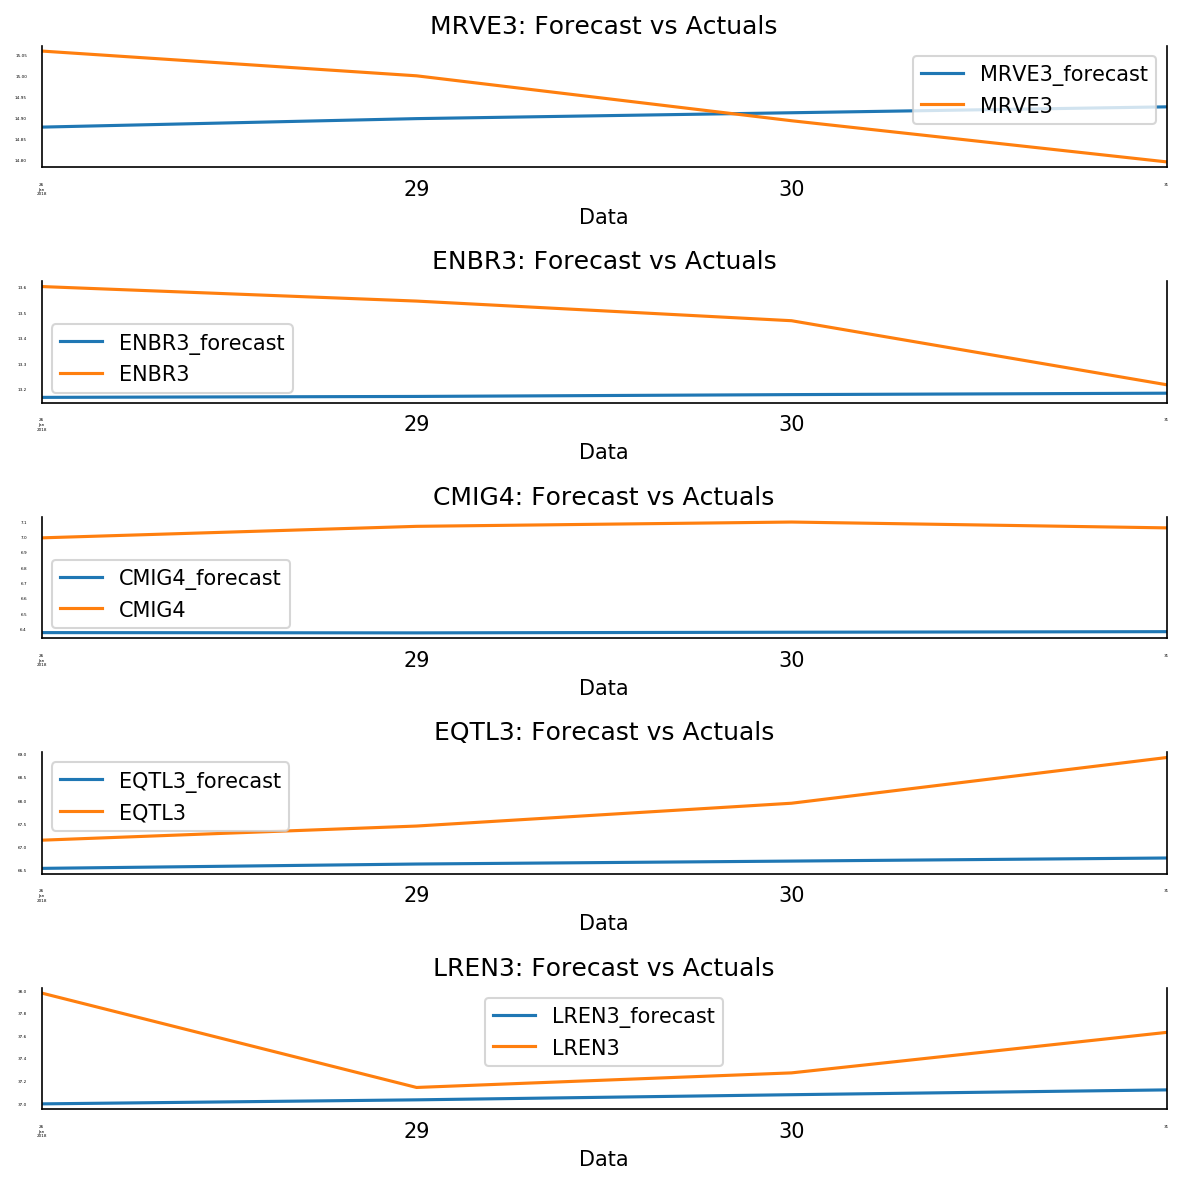

In [28]:
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=150, figsize=(8,8))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=2)

plt.tight_layout();

# <font color='green'>**PASSO 12:**</font> Analisando os resultados obtidos

In [21]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: MRVE3')
accuracy_prod = forecast_accuracy(df_results['MRVE3_forecast'].values, df_test['MRVE3'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: ENBR3')
accuracy_prod = forecast_accuracy(df_results['ENBR3_forecast'].values, df_test['ENBR3'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: CMIG4')
accuracy_prod = forecast_accuracy(df_results['CMIG4_forecast'].values, df_test['CMIG4'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: EQTL3')
accuracy_prod = forecast_accuracy(df_results['EQTL3_forecast'].values, df_test['EQTL3'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: LREN3')
accuracy_prod = forecast_accuracy(df_results['LREN3_forecast'].values, df_test['LREN3'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: MRVE3
mape   :  0.0072
me     :  -0.0333
mae    :  0.1083
mpe    :  -0.0022
rmse   :  0.1233
corr   :  -0.978
minmax :  0.0072

Forecast Accuracy of: ENBR3
mape   :  0.0209
me     :  -0.2829
mae    :  0.2829
mpe    :  -0.0209
rmse   :  0.3216
corr   :  -0.9445
minmax :  0.0209

Forecast Accuracy of: CMIG4
mape   :  0.0959
me     :  -0.6762
mae    :  0.6762
mpe    :  -0.0959
rmse   :  0.6772
corr   :  0.2351
minmax :  0.0959

Forecast Accuracy of: EQTL3
mape   :  0.0177
me     :  -1.2099
mae    :  1.2099
mpe    :  -0.0177
rmse   :  1.3497
corr   :  0.9435
minmax :  0.0177

Forecast Accuracy of: LREN3
mape   :  0.0119
me     :  -0.4478
mae    :  0.4478
mpe    :  -0.0119
rmse   :  0.5631
corr   :  -0.272
minmax :  0.0119


# <font color='green'>**PASSO 13:**</font> Parâmetros do modelo

Abaixo são obtidas:
* A matriz A1 que é a matriz de coeficientes que define o modelo VAR de ordem 1
* A matriz de covariância dos erros dos modelo
 * Para cada dia de previsão, há uma matriz de covariância

In [22]:
A1 = model_fitted.coefs
print(f'Matriz A1: \n {A1[0]}')
print('\n') 

Matriz A1: 
 [[-0.04936955 -0.0813877   0.07319154  0.0057182  -0.02472659]
 [ 0.0318343  -0.16970697  0.0306311   0.02583509 -0.02119694]
 [ 0.02387289  0.08480396 -0.04826557  0.00758198 -0.01481816]
 [ 0.05239736  0.28386079  0.028465   -0.10444819 -0.11612038]
 [ 0.19716294 -0.10842934 -0.02220079  0.01629405 -0.06283951]]




In [23]:
cov = model_fitted.mse(nobs)
for i in range(nobs):
    print(f'Matriz de covariância para a primeira previsão: \n {cov[i]}')
    print('\n') 

Matriz de covariância para a primeira previsão: 
 [[0.0492573  0.0176348  0.01626563 0.05123491 0.04292923]
 [0.0176348  0.03922002 0.0204192  0.05833901 0.03617614]
 [0.01626563 0.0204192  0.05183074 0.06961116 0.04633338]
 [0.05123491 0.05833901 0.06961116 0.4924424  0.13601917]
 [0.04292923 0.03617614 0.04633338 0.13601917 0.21862277]]


Matriz de covariância para a primeira previsão: 
 [[0.04986476 0.01813697 0.01596265 0.05119948 0.04292781]
 [0.01813697 0.04018    0.02012654 0.0570872  0.03694128]
 [0.01596265 0.02012654 0.05216173 0.07000673 0.04647511]
 [0.05119948 0.0570872  0.07000673 0.50065489 0.13628361]
 [0.04292781 0.03694128 0.04647511 0.13628361 0.22057282]]


Matriz de covariância para a primeira previsão: 
 [[0.04988955 0.01816798 0.01594745 0.05114703 0.04293338]
 [0.01816798 0.04022853 0.02011025 0.05700048 0.03696424]
 [0.01594745 0.02011025 0.05217209 0.0700372  0.04647779]
 [0.05114703 0.05700048 0.0700372  0.50088669 0.13626624]
 [0.04293338 0.03696424 0.046477

# Conclusão

Neste arquivo fizemos previsões de cinco ativos negociados na B3 utilizando um modelo VAR. Verificamos todas as hipóteses necessárias para aplicar o modelo VAR e as alterações que devem ser feitas quando as séries históricas não atendem aos requesitos. Fizemos a inversão para a escala original dos dados e plotamos as previsões *versus* os dados reais. Por fim, analisamos as medidas estatísticas dos valores previstos. Esperamos que este material tenha sido útil para você conseguir fazer suas próprias previsões.

# Referências

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

https://www.sciencedirect.com/topics/economics-econometrics-and-finance/var-model

https://s3.amazonaws.com/assets.datacamp.com/production/course_4267/slides/chapter5.pdf

https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio/